In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets  # interactive display

In [2]:
## inputs
durations = [0, 17, 33, 67, 134, 267, 533]
fixed_duration = 134
total_duration = 1200 # in ms 
var_duration = np.vstack([np.hstack((np.ones(duration), np.zeros(total_duration - duration))) for duration in durations])
var_isi = np.vstack([np.hstack((np.ones(fixed_duration), np.zeros(duration), np.ones(fixed_duration), np.zeros(total_duration- duration - 2*fixed_duration))) for duration in durations])

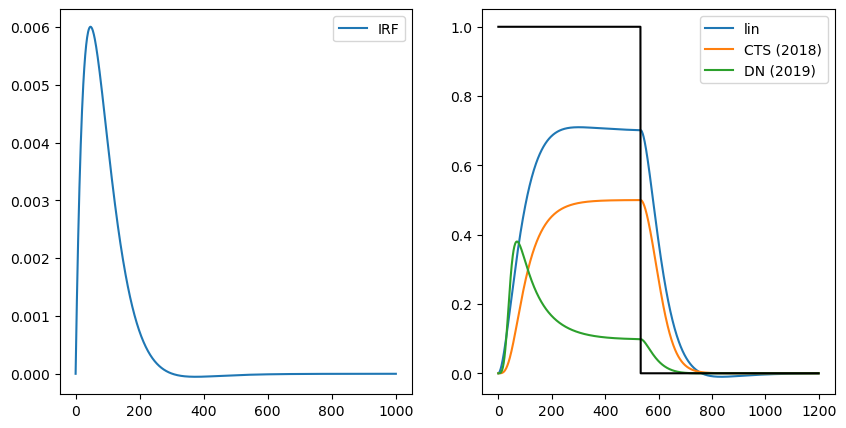

In [8]:
# cleaned up
def compute_irf(t, tau, omega = 0.0, transient_factor = 1.5):
    """
    computes neuronal impulse response function with "Gamma shape"
    according to Zhou et al 2018 and 2019. The function implements
    the scheme proposed by Zhou et al. 2019, where the IRF is defined
    as a difference between a primary and secondary transient response.
    
    Setting omega to 0 recovers the scheme from Zhou et al. 2018
    
    parameters
    t: np.array
        time array
    tau: float
        time constant of the neural response
    omega: float 
        weight of secondary, transient response
    transient_factor: float
        how much the secondary transient response is delayed compared
        to the initial response
        
    outputs
    irf: np.array
        resulting neural response
    """
    
    # compute initial response
    gamma_1 = t * np.exp(-t / tau)
    # normalize
    gamma_1 /= np.sum(gamma_1)
    
    # compute transient response
    gamma_2 = t * np.exp(-t/(1.5*tau))
    # normalize
    gamma_2 /= np.sum(gamma_2)
    
    # sum 
    irf = gamma_1 - omega * gamma_2
#     irf /= np.sum(irf)

    return irf


def compute_lin_response(t_inp, tau, dt=1.0, omega = 0.0, g = 1):
    
    """
    computes the linear response (R_lin) to a stimulus for a neuronal
    impulse response function (IRF) given parameters tau and omega, 
    according to Zhou et al. 2019.
    
    Setting omega to 0 recovers the scheme from Zhou et al. 2018 as
    the transient part of the IRF will not be considered.
    
    parameters:
    t_inp : np.array
        stimulus time course
    tau: float
        time constant of the neural response
    dt: float
        time step of t_inp in ms
    omega: float
        weight of secondary, transient response
    
    outputs:
    linear_response: np.array
        the computed linear response
    """
    t_irf = np.arange(0, 5000 + dt, dt)
    linear_response = np.convolve(t_inp, compute_irf(t_irf, tau, omega))[:len(t_inp)]
    
    return g * linear_response


def comp_temp_sum(t_inp, tau, sigma, n = 2, dt=1.0, omega = 0.0, g = 1.0):
    """
    Implements the compressive temporal summation model from Zhou et al 2018
    
    parameters:
    t_inp : np.array
        stimulus time course
    tau: float
        time constant of the neural response
    dt: float
        time step of t_inp in ms
    omega: float
        weight of secondary, transient response
    g: float
        scale or gain factor
    
    outputs:
    cts: np.array
        the computed compressive temporal summation response
    """
    cts = g * (compute_lin_response(t_inp, tau, dt, omega))**2/ (sigma ** 2 + (compute_lin_response(t_inp, tau, dt, omega))**2)
    
    return cts

def delayed_normalization(t_inp, tau_1, tau_2, n, sigma, dt=1.0, omega = 0.0, g = 1):
    """
    Implements the delayed normalization model from Zhou et al 2019
    $$
    R_{DN} = \frac{R_{LN}}{\sigma^n + (|R_{LN}| * h_2(\tau_2))^n}
    $$
    
    parameters:
    t_inp : np.array
        stimulus time course
    tau_1: float
        time constant of the neural response
    tau_2: float
        time constant of the neural response for normalization pool
    n: float
        exponent of sigma and the normalization pool
    sigma: float
        semisaturation constant
    dt: float
        time step of t_inp in ms
    omega: float
        weight of secondary, transient response
    g: float
        scale or gain factor
    
    TODO
    - implement shift
    """
    
    linear_response = compute_lin_response(t_inp, tau_1, dt, omega)
    
    
    numerator = np.abs(linear_response)**n
    
    denominator = sigma**n + np.convolve(np.abs(linear_response)**n, np.exp(-t/tau_2))[:len(linear_response)]
    
    norm_response = g * (numerator / denominator)
    
    return norm_response


fig, axes = plt.subplots(1,2, figsize = (10, 5))

## test params
t_irf = np.linspace(0, 1000, 1000) # changing the amount of points here has the same effect as changing tau, keeping the same resolution btw t_irf and T_input is thus very important
dt = 1
t_irf = np.arange(0, 1000 + dt, dt)
tau = 50
tau_1 = 50
tau_2 = 100
n = 2
sigma = 1
omega = .3
t = np.linspace(0, 2000, 2000)

axes[0].plot(t_irf, compute_irf(t_irf, tau, omega = 0.3), label = 'IRF')
axes[1].plot(compute_lin_response(var_duration[6], tau, dt, omega = omega), label = 'lin')
axes[1].plot(comp_temp_sum(var_duration[6], tau, sigma, dt = dt, omega=0, g = 1), label = 'CTS (2018)')
axes[1].plot(delayed_normalization(var_duration[6], tau_1, tau_2, n, sigma, dt, omega, g = 10), label = 'DN (2019)')

axes[1].plot(var_duration[6], color = 'black')

for ax in axes:
    ax.legend()

# def R_lin(t, tau, g, T_inp, version = '2018', omega = 1):


In [21]:
def plot_predicitons(tau_lin, tau_cts, tau_1_dn, tau_2_dn, omega, sigma_cts, 
                     sigma_dn, n_dn, g_lin, g_cts, g_dn, inputs = var_isi, include = ['lin', 'cts', 'dn']):
    
    durations = [0, 17, 33, 67, 134, 267, 533]

    fig, axs = plt.subplots(ncols=2, nrows=7, figsize = (12, 6))
    gs = axs[0, 1].get_gridspec()
    # remove the underlying axes
    for ax in axs[:, -1]:
        ax.remove()
    axbig = fig.add_subplot(gs[:, -1])

    pred_bold_amplitudes = np.zeros((len(inputs), 3))

    for i, ax in enumerate(axs[:, 0]):
        lin_resp = compute_lin_response(inputs[i], tau_lin, dt = 1, omega = omega, g = g_lin)
        cts_resp = comp_temp_sum(inputs[i], tau_cts, sigma_cts, dt = dt, omega=0, g = g_cts)    
        dn_resp = delayed_normalization(inputs[i], tau_1_dn, tau_2_dn, n_dn, sigma_dn, dt, omega, g = g_dn)

        pred_bold_amplitudes[i] = np.sum(lin_resp), np.sum(cts_resp), np.sum(dn_resp)
        
        if 'lin' in include:
            ax.plot(lin_resp, label = 'lin')
        if 'cts' in include:   
            ax.plot(cts_resp, label = 'CTS')
        if 'dn' in include:
            ax.plot(dn_resp, label = 'DN')

        ax.plot(inputs[i], color = 'black')

    axbig.plot(durations, pred_bold_amplitudes)
    axbig.legend(['lin', 'CTS', 'DN'])    
#     axbig.set_ylim(0, 600)

In [22]:
import ipywidgets as widgets
from IPython.display import display

# Define interactive widget controls
tau_lin_slider = widgets.FloatSlider(value=50, min=1.0, max=1000.0, step=5.0, description='tau_lin (ms):')
tau_cts_slider = widgets.FloatSlider(value=50, min=1.0, max=1000.0, step=5.0, description='tau_cts (ms):')
tau_1_dn_slider = widgets.FloatSlider(value=50, min=1.0, max=1000.0, step=5.0, description='tau_1_dn (ms):')
tau_2_dn_slider = widgets.FloatSlider(value=100, min=1.0, max=1000.0, step=5.0, description='tau_2_dn (ms):')
omega_slider = widgets.FloatSlider(value=0.0, min=0.0, max=1.0, step=0.01, description='omega:')
sigma_cts_slider = widgets.FloatSlider(value=0.1, min=0.001, max=1.0, step=0.001, description='sigma_cts:')
sigma_dn_slider = widgets.FloatSlider(value=0.1, min=0.0, max=1.0, step=0.01, description='sigma_dn:')
n_dn_slider = widgets.FloatSlider(value=2.0, min=0.0, max=6.0, step=.1, description='n_dn:')
g_lin_slider = widgets.FloatSlider(value=1.0, min=0.0, max=10.0, step=.1, description='g_lin:')
g_cts_slider = widgets.FloatSlider(value=1, min=0.0, max=10.0, step=.01, description='g_cts:')
g_dn_slider = widgets.FloatSlider(value=5, min=0.0, max=100.0, step=.1, description='g_dn:')

# selections
plot_lin = widgets.Dropdown(options=[True, False], value=True, description='plot_lin:')
plot_cts = widgets.Dropdown(options=[True, False], value=True, description='plot_cts:')
plot_dn = widgets.Dropdown(options=[True, False], value=True, description='plot_dn:')
plot_stim = widgets.Dropdown(options=[True, False], value=True, description='plot_stim:')


# Group sliders into columns
column1 = widgets.VBox([tau_lin_slider, g_lin_slider]) # linear params
column2 = widgets.VBox([tau_cts_slider, sigma_cts_slider, g_cts_slider]) # cts params
column3 = widgets.VBox([tau_1_dn_slider, tau_2_dn_slider, sigma_dn_slider, omega_slider, n_dn_slider, g_dn_slider]) # DN sliders

# Arrange columns horizontally
ui = widgets.HBox([column1, column2, column3])

# Create interactive output
out = widgets.interactive_output(plot_predicitons, {'tau_lin':tau_lin_slider, 
                                                    'tau_cts':tau_cts_slider, 
                                                    'tau_1_dn':tau_1_dn_slider, 
                                                    'tau_2_dn':tau_2_dn_slider, 
                                                    'omega':omega_slider, 
                                                    'sigma_cts':sigma_cts_slider, 
                                                    'sigma_dn':sigma_dn_slider, 
                                                    'n_dn':n_dn_slider, 
                                                    'g_lin':g_lin_slider, 
                                                    'g_cts':g_cts_slider, 
                                                    'g_dn':g_dn_slider})

# Display widgets and output
display(ui, out)


Output()

How to scale shiot properly -> look into Zhou

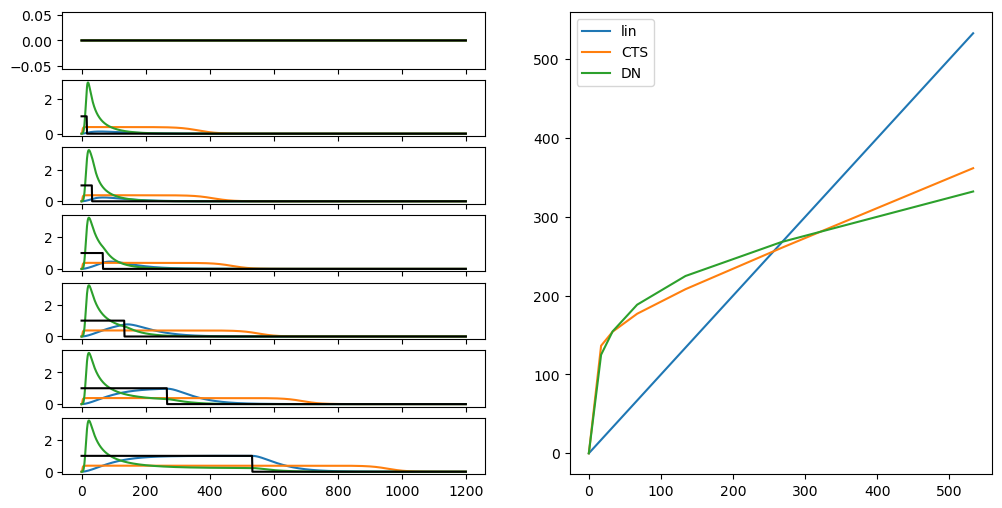

In [17]:
plot_predicitons(tau_lin=50, tau_cts=50, tau_1_dn=50, tau_2_dn=100, omega=0, sigma_cts=.002, 
                     sigma_dn=.1, n_dn=2, g_lin=1, g_cts=.38, g_dn=22.7, inputs = var_duration)

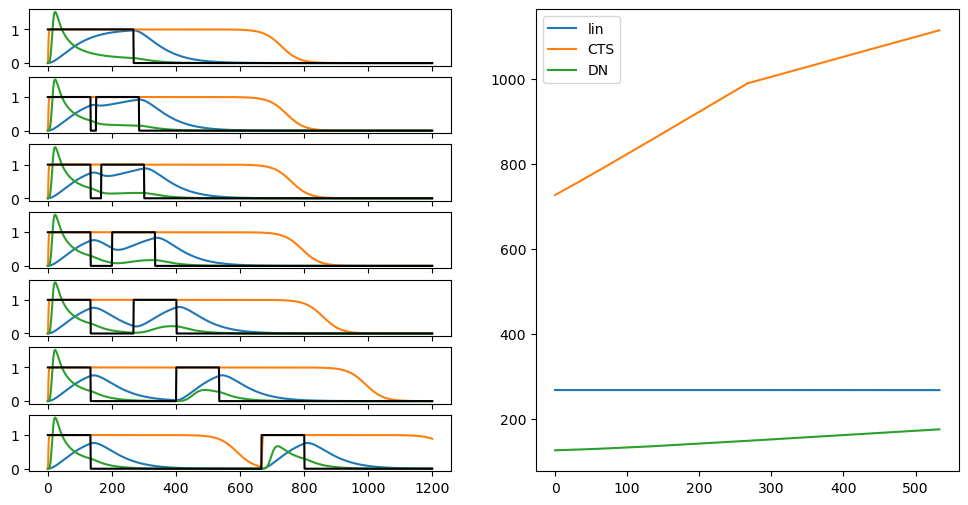

In [20]:
plot_predicitons(tau_lin=50, tau_cts=50, tau_1_dn=50, tau_2_dn=100, omega=0, sigma_cts=.001, 
                     sigma_dn=.1, n_dn=2, g_lin=1, g_cts=1, g_dn=10.7, inputs = var_isi)

Text(0.5, 0.98, 'Reproduction Zhou et al 2018, Fig 4B')

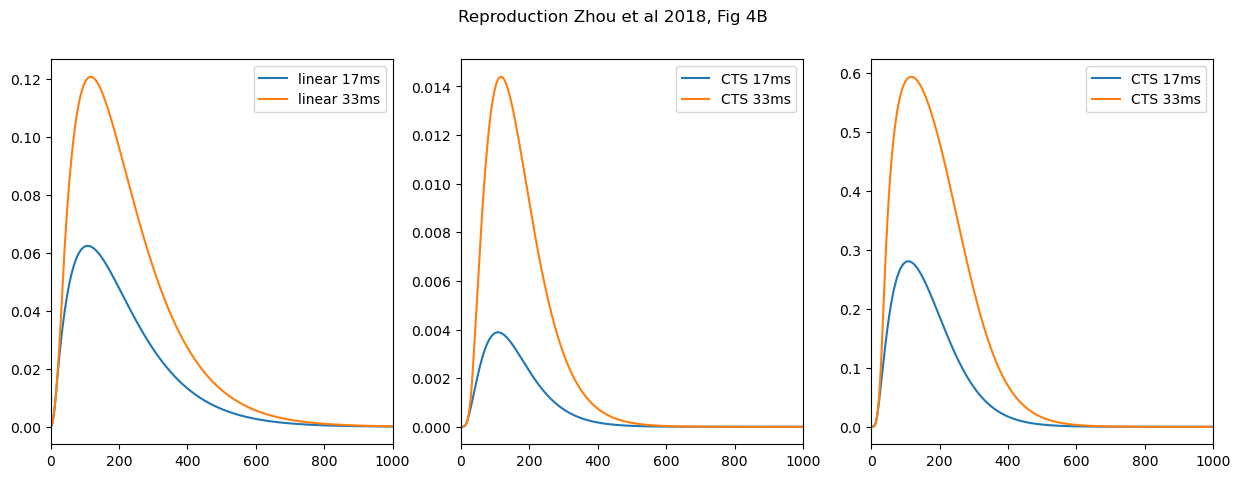

In [29]:
fig, ax = plt.subplots(1,3, figsize = (15, 5))
tau = 100
t = np.linspace(0, 2000, 2000)
# t = np.linspace(0, 1, 2000)
sigma = 1
g = 1

# ax.plot(IRF(t, tau)* 10)
# ax.plot(var_duration[1], label = 'stimulus')
ax[0].plot(compute_lin_response(var_duration[1], tau, g=g), label = 'linear 17ms')
ax[1].plot(comp_temp_sum(var_duration[1], tau, sigma, g=g), label = 'CTS 17ms')

ax[0].plot(compute_lin_response(var_duration[2], tau, g=g), label = 'linear 33ms')
ax[1].plot(comp_temp_sum(var_duration[2], tau, sigma, g=g), label = 'CTS 33ms')

sigma = .1
ax[2].plot(comp_temp_sum(var_duration[1], tau, sigma, g=g), label = 'CTS 17ms')
ax[2].plot(comp_temp_sum(var_duration[2], tau, sigma, g=g), label = 'CTS 33ms')

for axis in ax:
    axis.legend()
    axis.set_xlim(0, 1000)


    #ax.plot(IRF(t, tau))
plt.legend()
fig.suptitle("Reproduction Zhou et al 2018, Fig 4B")

In [168]:
def predict(tau_lin, tau_cts, tau_1_dn, tau_2_dn, omega, sigma_cts, 
             sigma_dn, n_dn, g_lin, g_cts, g_dn, inputs = var_duration):
    
    # placeholder for predicted BOLD amplitudes 
    pred_bold_amplitudes = np.zeros((len(inputs), 3))
    
    for i, inp in enumerate(inputs):

        # calculate responses
        lin_resp = compute_lin_response(inputs[i], tau_lin, dt = 1, omega = omega, g = g_lin)
        cts_resp = comp_temp_sum(inputs[i], tau_cts, sigma_cts, dt=dt, omega=0, g = g_cts)    
        dn_resp = delayed_normalization(inputs[i], tau_1_dn, tau_2_dn, n_dn, sigma_dn, dt, omega, g = g_dn)

        # calculate BOLD amplitude predictios
        pred_bold_amplitudes[i] = np.sum(lin_resp), np.sum(cts_resp), np.sum(dn_resp)

    return pred_bold_amplitudes

amplitude_predictions_dur = predict(tau_lin=50, tau_cts=50, tau_1_dn=50, tau_2_dn=100, omega=0, sigma_cts=.002, 
        sigma_dn=.1, n_dn=2, g_lin=1, g_cts=.38, g_dn=22.7, inputs = var_duration)

amplitude_predictions_isi = predict(tau_lin=50, tau_cts=50, tau_1_dn=50, tau_2_dn=100, omega=0, sigma_cts=.002, 
        sigma_dn=.1, n_dn=2, g_lin=1, g_cts=.38, g_dn=22.7, inputs = var_isi)

In [175]:
(amplitude_predictions_dur/60)[:,2]

array([0.        , 2.08383017, 2.57835059, 3.14253064, 3.74924059,
       4.46733999, 5.53698063])

In [176]:
(amplitude_predictions_isi/60)[:,2]

array([4.47183704, 4.50279837, 4.53482855, 4.61309987, 4.80378286,
       5.25839723, 6.2118321 ])

### Deprecated

2999


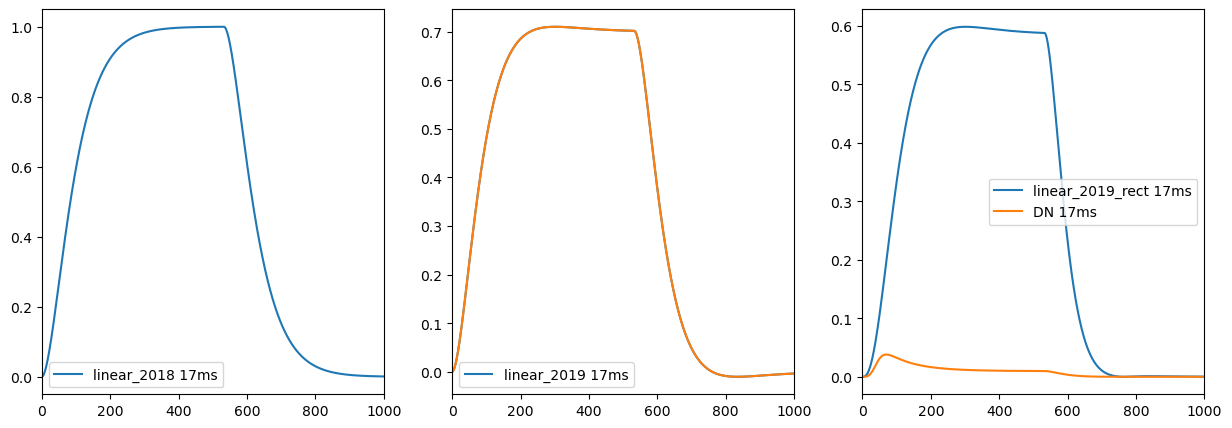

In [200]:
fig, ax = plt.subplots(1,3, figsize = (15, 5))
tau = 50
tau_2 = 100

t = np.linspace(0, 2000, 2000)
# t = np.linspace(0, 1, 2000)
sigma = 1
g = 1
n=2
print(len(lin))
# ax.plot(IRF(t, tau)* 10)
# ax.plot(var_duration[1], label = 'stimulus')
ax[0].plot(R_lin(t, tau, g, var_duration[6], version='2018'), label = 'linear_2018 17ms')
ax[1].plot(R_lin(t, tau, g, var_duration[6], version='2019', omega = 0.3), label = 'linear_2019 17ms')
ax[2].plot(rectify_exponentiate(R_lin(t, tau, g, var_duration[6], version='2019', omega = 0.3),1.5), label = 'linear_2019_rect 17ms')
lin = R_lin(t, tau, g, var_duration[6], version='2019', omega = 0.3)
ax[1].plot(lin)
ax[2].plot(delayed_normalization(t, lin,n,sigma,tau_2), label = 'DN 17ms')

# ax[0].plot(R_lin(t, tau, g, var_duration[2]), label = 'linear 33ms')
# ax[1].plot(cts(t, sigma, g, tau, var_duration[2]), label = 'CTS 33ms')

# sigma = .01
# ax[2].plot(cts(t, sigma, g, tau, var_duration[1]), label = 'CTS 17ms')
# ax[2].plot(cts(t, sigma, g, tau, var_duration[2]), label = 'CTS 33ms')

for axis in ax:
    axis.legend()
    axis.set_xlim(0, 1000)
#     axis.set_ylim(0,.15)


    #ax.plot(IRF(t, tau))
plt.legend()
# fig.suptitle("Reproduction Zhou et al 2018, Fig 4B")